In [1]:

# -*- coding: utf-8 -*-
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:522: FutureWarning: Passing (type, 1) or '1type' as

* 以 ResNet-50 預訓練模型為基礎，建立與訓練花朵辨識模型的程式碼

In [15]:
#資料路徑
DATASET_PATH  = 'C:/pjwu/homework/ml100-03-final/image_data/data/'
TEST_PATH = 'C:/pjwu/homework/ml100-03-final/image_data/test/'
OUTPUT_PATH = 'C:/pjwu/homework/'

In [17]:
# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# saved model
WEIGHTS_FINAL = 'model-resnet50-final.h5'

SEED = 18

In [18]:
#資料匯入
#透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/val',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


Found 1974 images belonging to 5 classes.
Found 845 images belonging to 5 classes.


In [32]:
train_batches.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [19]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [20]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

In [21]:
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/20
123/123 [==============================] - 2345s 19s/step - loss: 1.5690 - acc: 0.3823 - val_loss: 0.7720 - val_acc: 0.7284
Epoch 2/20
123/123 [==============================] - 2295s 19s/step - loss: 0.8946 - acc: 0.6556 - val_loss: 0.4867 - val_acc: 0.8329
Epoch 3/20
123/123 [==============================] - 2263s 18s/step - loss: 0.6354 - acc: 0.7539 - val_loss: 0.3813 - val_acc: 0.8534
Epoch 4/20
123/123 [==============================] - 2260s 18s/step - loss: 0.5312 - acc: 0.8132 - val_loss: 0.3294 - val_acc: 0.8642
Epoch 5/20
123/123 [==============================] - 2330s 19s/step - loss: 0.4375 - acc: 0.8396 - val_loss: 0.3022 - val_acc: 0.8858
Epoch 6/20
123/123 [==============================] - 2347s 19s/step - loss: 0.4024 - acc: 0.8493 - val_loss: 0.2647 - val_acc: 0.9062
Epoch 7/20
123/123 [==============================] - 2289s 19s/step - loss: 0.3452 - acc: 0.8704 - val_loss: 0.2563 - val_acc: 0.9099
Epoch 8/20
123/123 [==============================] - 2

In [22]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

In [ ]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]

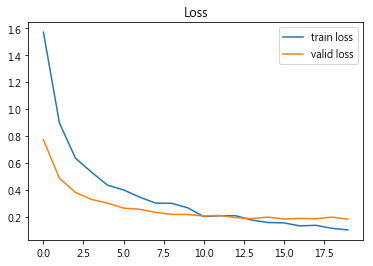

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

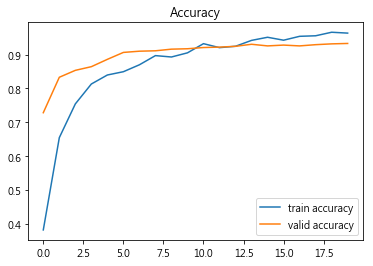

In [28]:
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()